# Understanding the ELO score: A practical example on the English Premier League using Python

Elo score is originating from chess, it was invented by a Hungarian matematician called Arpad Elo to rank chess players. It has many features which makes it possible to be used in other fileds such as: sports, and video games to rank people.

In our case we will do this for football teams, which will make it possible to rank and calculate winning probabilites for them.

In this example I will show you how to calculate ELO score for English Premier league football clubs using Python using our own functions.

The packages we need:

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Get data and load it:

For this example we need the results for multiple season of the English premier league. We can find data for this one on the following link: https://www.football-data.co.uk/englandm.php  
I downloaded data for 6 seasons and put all if them to a folder called: 'data/pl' in our root directory. (I also renamed them as this: 'data/pl/pl_2019_2020.csv')

Then I wrote a function to read in all the '.csv' files in one folder, in our case the 'data/pl' folder. ALso it does some minimal clean up.

In [2]:
def read_in_data_from_folder(path = 'data/pl', columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'filename'], print=False):
    """
    Read in all csv files from a folder and concatonate it into one pandas dataframe.
    """
    all_files = glob.glob(os.path.join(path , "*.csv"))
    if print:
        print(all_files)

    pd_base = pd.DataFrame()

    for filename in all_files:
        if print:
            print(filename)
        df = pd.read_csv(filename)
        df['filename'] = filename # add filename path as column
        pd_base = pd.concat([pd_base, df], ignore_index=True)

    # Keep only some columns
    # If columns_to_keep is not empty, keep only those columns. If empty, keep all columns:
    if columns_to_keep:
        pd_base = pd_base[columns_to_keep]

    # If there is a 'Date' column then convert it to datetime with format '%d/%m/%Y':
    if 'Date' in pd_base.columns:
        pd_base['Date'] = pd.to_datetime(pd_base['Date'], format='%d/%m/%Y')

    return pd_base

This data contains many other information but we only need some of the columns (actualy we only need the result, for calculating the ELO score).

In [3]:
results_data = read_in_data_from_folder(path = 'data/pl', columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'filename'], print=False)

We can look at the data now, to have a better understanding about what are we dealing with:

In [4]:
results_data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,filename
0,2017-08-11,Arsenal,Leicester,4,3,H,data/pl\pl_2017_2018.csv
1,2017-08-12,Brighton,Man City,0,2,A,data/pl\pl_2017_2018.csv
2,2017-08-12,Chelsea,Burnley,2,3,A,data/pl\pl_2017_2018.csv
3,2017-08-12,Crystal Palace,Huddersfield,0,3,A,data/pl\pl_2017_2018.csv
4,2017-08-12,Everton,Stoke,1,0,H,data/pl\pl_2017_2018.csv
...,...,...,...,...,...,...,...
1924,2022-08-20,Leicester,Southampton,1,2,A,data/pl\pl_2022_2023.csv
1925,2022-08-20,Bournemouth,Arsenal,0,3,A,data/pl\pl_2022_2023.csv
1926,2022-08-21,Leeds,Chelsea,3,0,H,data/pl\pl_2022_2023.csv
1927,2022-08-21,West Ham,Brighton,0,2,A,data/pl\pl_2022_2023.csv


The date is prety self explanatory: Each line is a match where there is a HomeTeam and an AwayTeam. With the FTHG (Full Time Home Goals) and the FTAG (Full Time Away Goals) and the FTR (Full time results). The FTR can be: 'H' if the home team won, 'A' if the away team won and 'D' if the match was a draw.

We can see that this data contains almost 2000 matches. My plan is to use 1-2 seasons to calibrate the ELO scores then see whether the aproach works on the 2nd part of the last season.

## Calculate league table based on the results

What we need to do is to create a league table, which calculates new scores at each time when a match is played. This is someting similar if we calculate a ranking at each point. So at this part we will do two things:  
1) create a league_table what we can update at each match
2) create the function which updates this table.

First we will not focus on the ELO score, but implement just the calculation based on the normal football rules, where each win worth +3 ponts for the wining team, 0 points for the losing team and 1 point for each team if there is a draw.

Later our plan is to add our ELO score calculation here.

### 1) Create League Table:

In [5]:
def create_league_table(data):
    
    unique_team_names = data['HomeTeam'].unique()

    league_table = pd.DataFrame()

    league_table['team'] = unique_team_names
    league_table['ranking'] = 0
    league_table['points'] = 0
    league_table['w'] = 0
    league_table['d'] = 0
    league_table['l'] = 0
    league_table['goals_for'] = 0
    league_table['goals_against'] = 0
    league_table['goal_difference'] = 0
    league_table['matched_played'] = 0
    league_table['last_date'] = 0

    # if there is colname 'Date', then we can use it to update 'last_date' column:
    if 'Date' in data.columns:
        league_table['last_date'] = min(data['Date'])
    else:
        league_table['last_date'] = 0
    
    return league_table

Do this for only the 2021-2022 season:

In [6]:
results_data_2022 = results_data[results_data['filename'] == r'data/pl\pl_2021_2022.csv']
lt_2022 = create_league_table(results_data_2022)
lt_2022

,team,ranking,points,w,d,l,goals_for,goals_against,goal_difference,matched_played,last_date
0,Brentford,0,0,0,0,0,0,0,0,0,2021-08-13
1,Man United,0,0,0,0,0,0,0,0,0,2021-08-13
2,Burnley,0,0,0,0,0,0,0,0,0,2021-08-13
3,Chelsea,0,0,0,0,0,0,0,0,0,2021-08-13
4,Everton,0,0,0,0,0,0,0,0,0,2021-08-13
5,Leicester,0,0,0,0,0,0,0,0,0,2021-08-13
6,Watford,0,0,0,0,0,0,0,0,0,2021-08-13
7,Norwich,0,0,0,0,0,0,0,0,0,2021-08-13
8,Newcastle,0,0,0,0,0,0,0,0,0,2021-08-13
9,Tottenham,0,0,0,0,0,0,0,0,0,2021-08-13


Now you can see that we have a table what we can update, but we need the updater function for it.

### 2) Write the function that updates the league table

First I will write this function_without the ELO score. We will be able to do some cool things with it, and in the next part we will add the ELO score.

In [7]:
def update_league_table(league_table, results_table):

    league_table_all = league_table.copy()
    league_table_new = league_table.copy()

    for index, row in results_table.iterrows():
        # get team names
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        # get match results
        home_team_goals = row['FTHG']
        away_team_goals = row['FTAG']
        full_time_result = row['FTR']
        # get date of match
        last_date = row['Date']

        # update 'matched_played' column:
        league_table_new.loc[league_table_new['team'] == home_team, 'matched_played'] += 1
        league_table_new.loc[league_table_new['team'] == away_team, 'matched_played'] += 1

        # update 'goals_for' and 'goals_against' columns:     
        league_table_new.loc[league_table_new['team'] == home_team, 'goals_for'] += home_team_goals
        league_table_new.loc[league_table_new['team'] == home_team, 'goals_against'] += away_team_goals
        league_table_new.loc[league_table_new['team'] == away_team, 'goals_for'] += away_team_goals
        league_table_new.loc[league_table_new['team'] == away_team, 'goals_against'] += home_team_goals

        # update 'last_date' column:
        league_table_new.loc[league_table_new['team'] == home_team, 'last_date'] = last_date

        # update 'ponts' and 'w', 'd', 'l' columns based on the result of the match:
        if full_time_result == 'H':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 3
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 0

            league_table_new.loc[league_table_new['team'] == home_team, 'w'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'l'] += 1

        elif full_time_result == 'A':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 0
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 3

            league_table_new.loc[league_table_new['team'] == home_team, 'l'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'w'] += 1
            
        elif full_time_result == 'D':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 1

            league_table_new.loc[league_table_new['team'] == home_team, 'd'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'd'] += 1
        else:
            print('Error: FTR is not H, A or D')

        # update 'goal_difference' column:
        league_table_new['goal_difference'] = league_table_new['goals_for'] - league_table_new['goals_against']

        # crate ranking based on points, goal difference, goals for and goals against
        league_table_new = league_table_new.sort_values(by=['points', 'goal_difference', 'goals_for', 'goals_against'], ascending=False)
        league_table_new = league_table_new.reset_index(drop=True)
        league_table_new['ranking'] = league_table_new.index + 1
        
        # update our data
        updated_row = league_table_new[(league_table_new['team'] == home_team) | (league_table_new['team'] == away_team)]
        league_table_all = pd.concat([league_table_all, updated_row], ignore_index=True)

    # reorder rows based on column points and goals_for:
    league_table_new = league_table_new.sort_values(by=['points', 'goal_difference', 'goals_for', 'goals_against'], ascending=False)
    league_table_new = league_table_new.reset_index(drop=True)
    
    return league_table_new, league_table_all

In [8]:
#results = results_data
results = results_data_2022

In [9]:
table_data = create_league_table(results)

In [10]:
new_table_data,  league_table_all= update_league_table(table_data, results)

In [11]:
new_table_data

,team,ranking,points,w,d,l,goals_for,goals_against,goal_difference,matched_played,last_date
0,Man City,1,93,29,6,3,99,26,73,38,2022-05-22
1,Liverpool,2,92,28,8,2,94,26,68,38,2022-05-22
2,Chelsea,3,74,21,11,6,76,33,43,38,2022-05-22
3,Tottenham,4,71,22,5,11,69,40,29,38,2022-05-15
4,Arsenal,5,69,22,3,13,61,48,13,38,2022-05-22
5,Man United,6,58,16,10,12,57,57,0,38,2022-05-02
6,West Ham,7,56,16,8,14,60,51,9,38,2022-05-15
7,Leicester,8,52,14,10,14,62,59,3,38,2022-05-22
8,Brighton,9,51,12,15,11,42,44,-2,38,2022-05-22
9,Wolves,10,51,15,6,17,38,43,-5,38,2022-05-15


Is this correct? We can check this if we go to one of the website with the official final results, see and example below:

![pl_original_league_table](img/league_table_original.png)

It is matching with our calculations, so we can see that our calculations are correct.

### Graphical representation
We can also create some nice plots to display some interesting aspects of our data.

Text(0.5, 1.0, 'Premier League 2021-2022 final results')

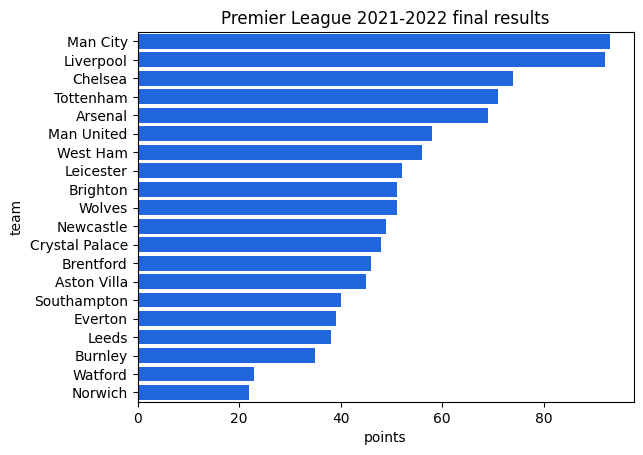

In [12]:
sns.barplot(x = 'points', y = 'team', data = new_table_data, color = '#035efc')
plt.title('Premier League 2021-2022 final results')

Text(0.5, 1.0, 'Premier League avarage points/ match in the 2021-2022 season')

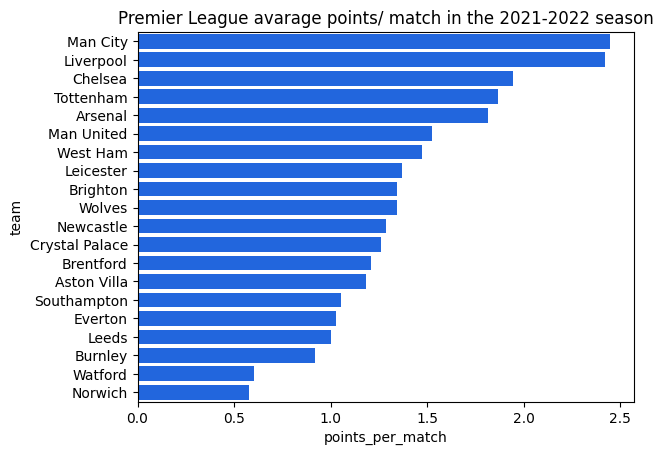

In [13]:
new_table_data['points_per_match'] = new_table_data['points'] / new_table_data['matched_played']
sns.barplot(x = 'points_per_match', y = 'team', data = new_table_data, color = '#035efc', order=new_table_data.sort_values('points_per_match', ascending = False).team)
plt.title('Premier League avarage points/ match in the 2021-2022 season')

We also created another table, called: 'league_table_all' which can be used to see the progression of the metrics. E.g.: If we want to see 3 teams points progression in time we can do that.

Text(0.5, 1.0, 'Premier League points over time')

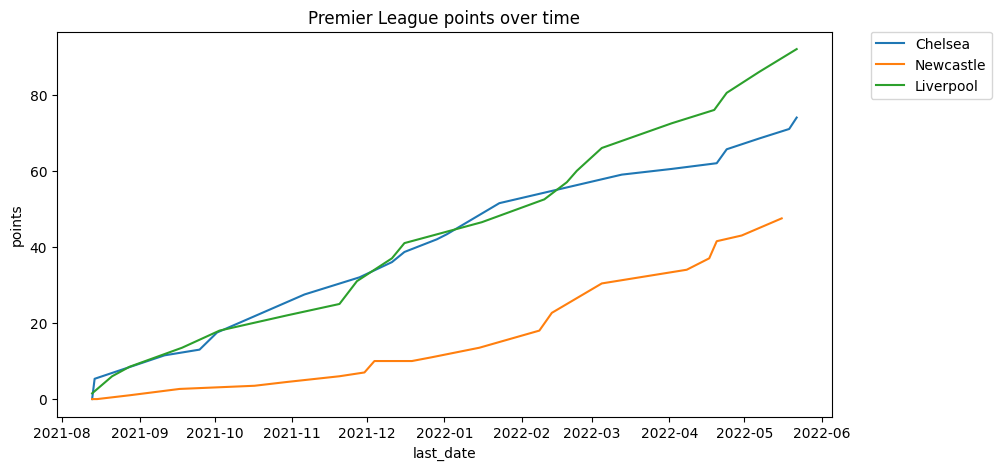

In [32]:
plt.figure(figsize = (10,5))
sns.lineplot(x='last_date', y='points', hue='team', ci = None,
    data=league_table_all[league_table_all['team'].isin(['Liverpool', 'Chelsea', 'Newcastle'])])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Premier League points over time')

## Adding the ELO score

In this part I am just copying the functions above and we will extending them with the ELO score calculations.

In [15]:
def create_league_table_elo(data, default_elo = 1500):
    unique_team_names = data['HomeTeam'].unique()

    league_table = pd.DataFrame()

    league_table['team'] = unique_team_names
    league_table['ranking'] = 0
    
    #we need to add the 'elo' column to the dataframe
    league_table['elo'] = default_elo
    
    league_table['points'] = 0
    league_table['w'] = 0
    league_table['d'] = 0
    league_table['l'] = 0
    league_table['goals_for'] = 0
    league_table['goals_against'] = 0
    league_table['goal_difference'] = 0
    league_table['matched_played'] = 0

    # if there is colname 'Date', then we can use it to update 'last_date' column:
    if 'Date' in data.columns:
        league_table['last_date'] = min(data['Date'])
    else:
        league_table['last_date'] = 0
    
    return league_table

For this part we will use all of our result set which contains the 5 previous seasons + the latest results from the 2022-2023 season.

Let's create the league table. Now we not only have 20 teams, but all the teams which were present in the PL for only one season too which adds up to 29.

In [36]:
results_data = read_in_data_from_folder(path = 'data/pl', columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'filename'], print=False)
league_table_elo = create_league_table_elo(results_data, default_elo = 1400)
print(league_table_elo['team'].to_list())

['Arsenal', 'Brighton', 'Chelsea', 'Crystal Palace', 'Everton', 'Southampton', 'Watford', 'West Brom', 'Man United', 'Newcastle', 'Bournemouth', 'Burnley', 'Leicester', 'Liverpool', 'Stoke', 'Swansea', 'Huddersfield', 'Tottenham', 'Man City', 'West Ham', 'Fulham', 'Wolves', 'Cardiff', 'Aston Villa', 'Norwich', 'Sheffield United', 'Leeds', 'Brentford', "Nott'm Forest"]


## Writing the ELO calculation function

To be able to calculate the ELO score, we need two things:
1) Calculate the expected probability of an outcome, based on two imput scores from the two opponents
2) Based on the actual result update the score with new values for each team.

We need three functions to be able to put the whole thing tohether:  

In [43]:
def expected_result_prob(home_score,away_score, weight = 400, home_field_advantage = 50):
  # calculate the expected probabilities for a match between two teams
  diff_h_a = home_score - away_score + home_field_advantage #here we can add home field advantage
  
  we = (1/(10**(-diff_h_a/weight)+1)) #the actual formula to calculate the expected probability
  
  home_team_prop = np.round(we,3)
  away_team_prob = 1-home_team_prop
  away_team_prob = np.round(away_team_prob,3)
  return home_team_prop, away_team_prob

As you see this function calculates the winning probability for both of the team.  
In this finction we can also introduce home field advantage by just adding a constant.
If you play with the parameters you can see how they are effecting the calculations.

In [44]:
print(expected_result_prob(1500,1400, weight=400))
print(expected_result_prob(1600,1400, weight=400))
print(expected_result_prob(1500,1400, weight=200))
print(expected_result_prob(1500,1400, weight=600))

(0.703, 0.297)
(0.808, 0.192)
(0.849, 0.151)
(0.64, 0.36)


Then we need a funcion to be able to know which team actualy won in real life. And based on that assign a value for the home and away team.

In [45]:
def actual_result(result):
  if result == 'H':
      home_team=1
      away_team=0
  elif result == 'A':
      home_team=0
      away_team=1
  elif result == 'D':
      home_team=0.5
      away_team=0.5
  return home_team, away_team

In [47]:
print(actual_result('H'))
print(actual_result('A'))
print(actual_result('D'))

(1, 0)
(0, 1)
(0.5, 0.5)


Then we need an updating function which will update the ELO score of both teams:

In [21]:
def calculate_elo(elo_home, elo_away, final_result, k_value = 40, weight = 400, home_field_advantage = 50):
  
  k=k_value

  erh, era = expected_result_prob(elo_home,elo_away, weight = weight, home_field_advantage = home_field_advantage)
  arh, ara = actual_result(final_result)

  # the actual formula to calculate the new elo
  updated_elo_home=elo_home + k*(arh-erh)
  updated_elo_away=elo_away + k*(ara-era)

  # round to nearest integer
  updated_elo_home=np.round(updated_elo_home, 3)
  updated_elo_away=np.round(updated_elo_away, 3)

  # just to calculate the stakes
  win_home = (1 - erh) * k
  lose_home = (0 - erh) * k
  draw_home = (0.5 - erh) * k
  win_away = (1 - era) * k
  lose_away = (0 - era) * k
  draw_away = (0.5 - era) * k
  stakes = [win_home, lose_home, draw_home, win_away, lose_away, draw_away]
  
  return updated_elo_home, updated_elo_away, stakes

In [22]:
calculate_elo(1500, 1400, 'H')

(1509.6, 1390.4, [9.6, -30.4, -10.4, 30.4, -9.6, 10.4])

In [23]:
calculate_elo(1500, 1400, 'A')

(1469.6, 1430.4, [9.6, -30.4, -10.4, 30.4, -9.6, 10.4])

Extend the leage table updater function with the ELO calculations:

In [24]:
def update_league_table(league_table, results_table, k_value = 40, weight = 400, home_field_advantage = 50):

    league_table_all = league_table.copy()
    league_table_new = league_table.copy()

    for index, row in results_table.iterrows():
        # get team names
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        # get match results
        home_team_goals = row['FTHG']
        away_team_goals = row['FTAG']
        full_time_result = row['FTR']
        # get date of match
        last_date = row['Date']
        # get elo of teams
        home_team_elo = league_table_new[league_table_new['team'] == home_team]['elo'].values[0]
        away_team_elo = league_table_new[league_table_new['team'] == away_team]['elo'].values[0]

        # update 'matched_played' column:
        league_table_new.loc[league_table_new['team'] == home_team, 'matched_played'] += 1
        league_table_new.loc[league_table_new['team'] == away_team, 'matched_played'] += 1

        # update 'goals_for' and 'goals_against' columns:     
        league_table_new.loc[league_table_new['team'] == home_team, 'goals_for'] += home_team_goals
        league_table_new.loc[league_table_new['team'] == home_team, 'goals_against'] += away_team_goals
        league_table_new.loc[league_table_new['team'] == away_team, 'goals_for'] += away_team_goals
        league_table_new.loc[league_table_new['team'] == away_team, 'goals_against'] += home_team_goals

        # update 'last_date' column:
        league_table_new.loc[league_table_new['team'] == home_team, 'last_date'] = last_date

        # update 'ponts' and 'w', 'd', 'l' columns based on the result of the match:
        if full_time_result == 'H':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 3
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 0

            league_table_new.loc[league_table_new['team'] == home_team, 'w'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'l'] += 1

        elif full_time_result == 'A':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 0
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 3

            league_table_new.loc[league_table_new['team'] == home_team, 'l'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'w'] += 1
            
        elif full_time_result == 'D':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 1

            league_table_new.loc[league_table_new['team'] == home_team, 'd'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'd'] += 1
        else:
            print('Error: FTR is not H, A or D')

        # update 'elo' score based on the result of the match:
        new_home_elo_score, new_away_elo_score, _ = calculate_elo(home_team_elo, away_team_elo, full_time_result, k_value = k_value, weight = weight, home_field_advantage = home_field_advantage)
        league_table_new.loc[league_table_new['team'] == home_team, 'elo'] = new_home_elo_score
        league_table_new.loc[league_table_new['team'] == away_team, 'elo'] = new_away_elo_score

        # update 'goal_difference' column:
        league_table_new['goal_difference'] = league_table_new['goals_for'] - league_table_new['goals_against']

        # crate ranking based on points, goal difference, goals for and goals against
        league_table_new = league_table_new.sort_values(by=['points', 'goal_difference', 'goals_for', 'goals_against'], ascending=False)
        league_table_new = league_table_new.reset_index(drop=True)
        league_table_new['ranking'] = league_table_new.index + 1
        
        # update our data
        updated_row = league_table_new[(league_table_new['team'] == home_team) | (league_table_new['team'] == away_team)]
        league_table_all = pd.concat([league_table_all, updated_row], ignore_index=True)

    # reorder rows based on column points and goals_for:
    league_table_new = league_table_new.sort_values(by=['points', 'goal_difference', 'goals_for', 'goals_against'], ascending=False)
    league_table_new = league_table_new.reset_index(drop=True)
    
    return league_table_new, league_table_all

Do the actual calculations using data from the 2017 season onwards.

In [48]:
results = read_in_data_from_folder(path = 'data/pl', columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'filename'], print=False)
league_table_elo = create_league_table_elo(results, default_elo=1400)
league_table_elo, league_table_elo_all = update_league_table(league_table_elo, results, k_value = 40, weight = 400, home_field_advantage = 60)

Here we can see:  
- The current elo score
- the totel score which was collected  

This results are based on 5 season + the current one too. (you can see the last date when the scores were updated for each team in the 'last_date' column)

In [49]:
league_table_elo

,team,ranking,elo,points,w,d,l,goals_for,goals_against,goal_difference,matched_played,last_date
0,Man City,1,1732.60,465,148,21,24,494,146,348,193,2022-08-13
1,Liverpool,2,1705.80,434,131,41,20,423,164,259,192,2022-08-15
2,Chelsea,3,1539.88,353,103,44,46,331,205,126,193,2022-08-14
3,Tottenham,4,1594.96,347,104,35,54,346,210,136,193,2022-08-20
4,Man United,5,1428.92,345,99,48,45,330,225,105,192,2022-08-07
5,Arsenal,6,1582.24,328,97,37,59,328,239,89,193,2022-08-13
6,Leicester,7,1412.04,280,79,43,71,309,266,43,193,2022-08-20
7,West Ham,8,1394.52,254,70,44,79,271,288,-17,193,2022-08-21
8,Everton,9,1347.24,251,69,44,80,234,278,-44,193,2022-08-20
9,Crystal Palace,10,1455.00,232,60,52,81,222,274,-52,193,2022-08-20


Text(0.5, 1.0, 'Elo score of teams')

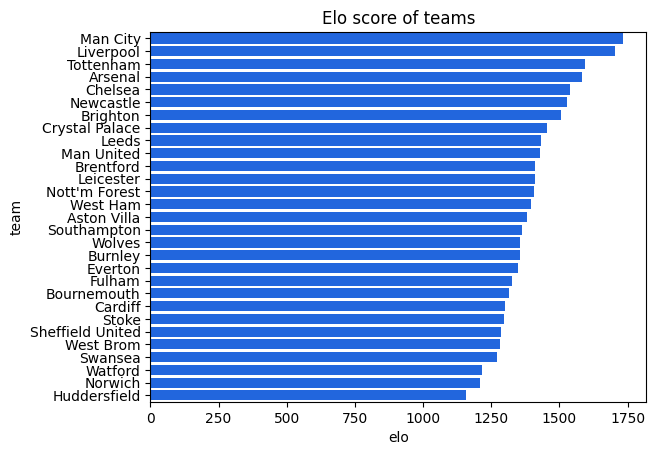

In [27]:
sns.barplot(x = 'elo', y = 'team', data = league_table_elo, color = '#035efc', order=league_table_elo.sort_values('elo', ascending = False).team)
plt.title('Elo score of teams')

We can also represent the progression of the scores in time, from a given date.
Remeber, that at the begining each team starts from the same score so it takes some time to converge to the real score, so at the begining of our series the score are not well calibrated and can be off. Thats why we do not want to look at the begining of our series.

Text(0.5, 1.0, 'ELO score progression for some PL clubs')

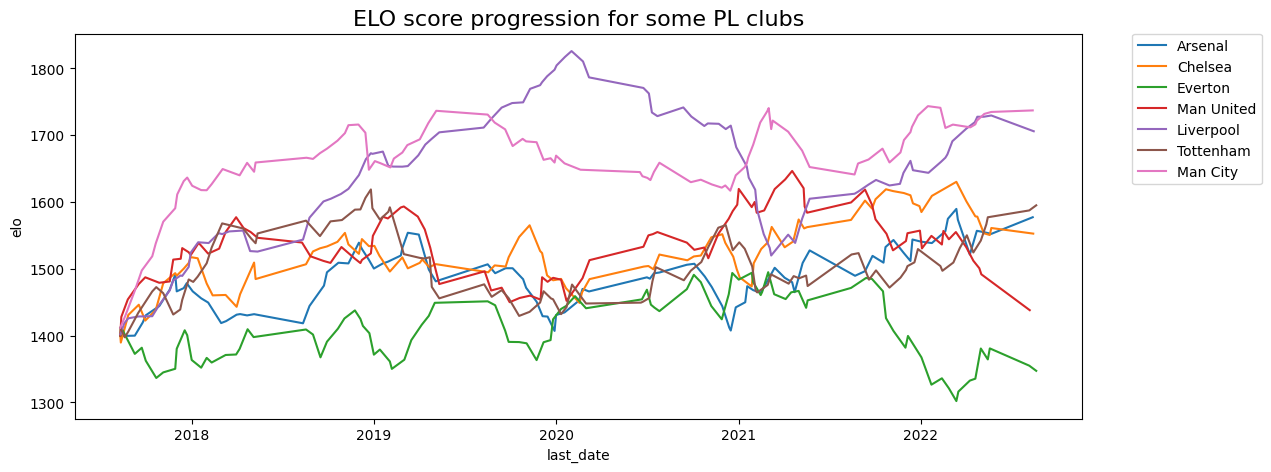

In [54]:
plt.figure(figsize = (13,5))
sns.lineplot(x='last_date', y='elo', hue='team', ci=None,
    data=league_table_elo_all[league_table_elo_all['team'].isin(['Arsenal', 'Chelsea', 'Liverpool', 'Man City', 'Man United', 'Tottenham', 'Everton'])])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ELO score progression for some PL clubs', size = 16)

Zommed in:

Text(0.5, 1.0, 'ELO score progression for some PL clubs')

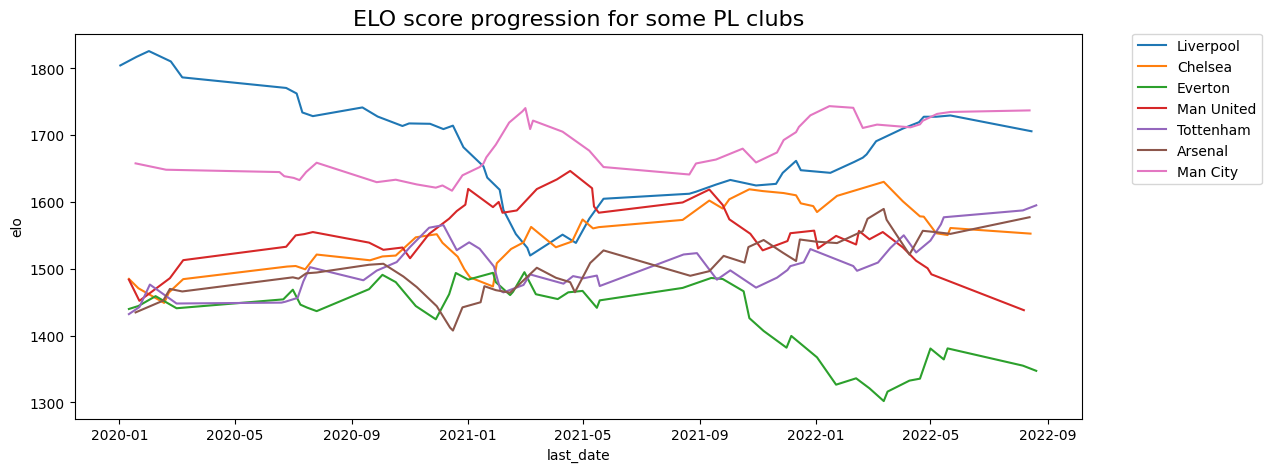

In [53]:
plt.figure(figsize = (13,5))
sns.lineplot(x='last_date', y='elo', hue='team', ci=None,
    data=league_table_elo_all[(league_table_elo_all['team'].isin(['Arsenal', 'Chelsea', 'Liverpool', 'Man City', 'Man United', 'Tottenham', 'Everton'])) & (league_table_elo_all['last_date'] > '2020-01-01')])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ELO score progression for some PL clubs', size = 16)

In [55]:
#plt.figure(figsize = (15,8))
#sns.lineplot(x='matched_played', y='elo', hue='team', ci = None,
#    data=league_table_elo_all[(league_table_elo_all['team'].isin(['Arsenal', 'Chelsea', 'Liverpool', 'Man City', 'Man United', 'Tottenham', 'Everton'])) & (league_table_elo_all['matched_played'] > 100)])
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Summary: